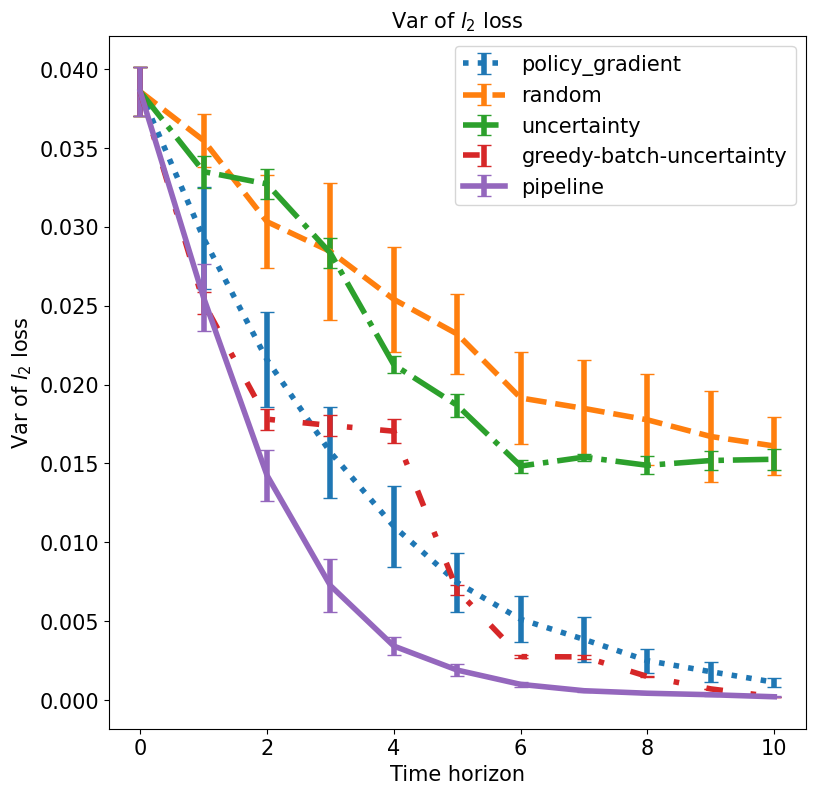

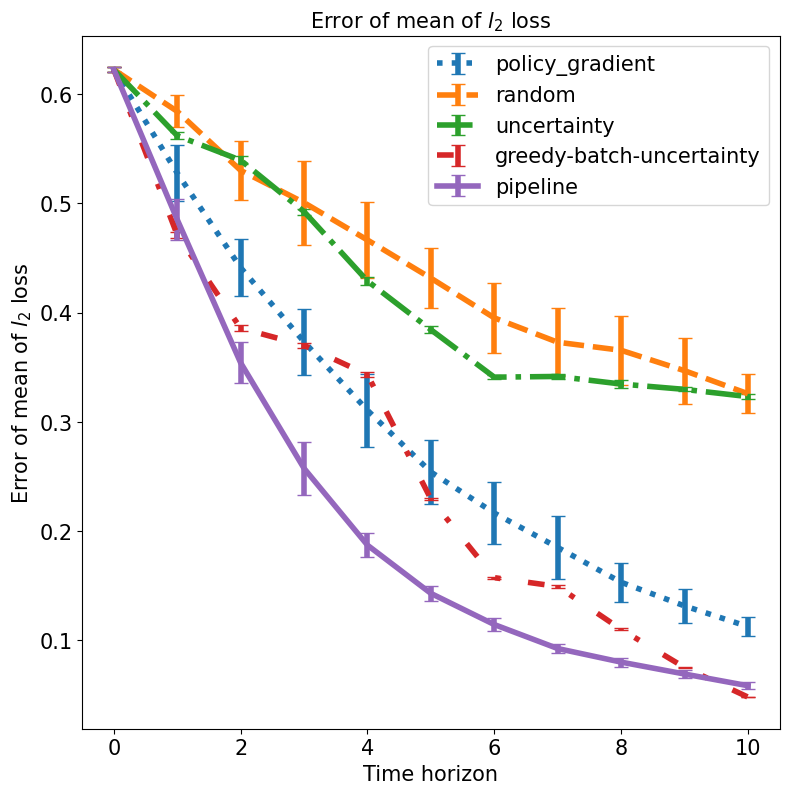

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#%config InlineBackend.figure_format = 'svg'

def good_index(Str):
    if 'MIN' in Str or 'MAX' in Str:
        return False
    else:
        return True
    
directory = './result_0519/'

fontsize = 15
true_l2_loss = 0.004542
line_styles = [':', '--', '-.', (0, (3, 5, 1, 5)), '-'] #, (, (3, 5, 1, 5))]  # Custom dash pattern


file_name = [['active_learning_var.csv', 'pipeline_var.csv', 'pg_var.csv'],
            ['active_learning_l2_loss.csv', 'pipeline_l2_loss.csv', 'pg_l2_loss.csv']
            ]
plotting_var_list = ['Var of $l_2$ loss', 'Error of mean of $l_2$ loss']

method_name = ['active', 'pipeline','policy_gradient']
dict_name = ['dictionary_active_learning.csv']

for j in range(2):
    plotting_var = plotting_var_list[j]
    for i in range(3):
        df_tmp = pd.read_csv(directory + file_name[j][i])
        del df_tmp['Step']

        df_tmp = df_tmp.transpose()
        df_tmp['sweep_id'] = df_tmp.index
        


        if i == 0:
            dict_val = pd.read_csv(directory + dict_name[i])
            key_list = list(dict_val['Name'])
            
            if j == 0:
                key_list = [_ + ' - var_square_loss_track' for _ in key_list]
            else:
                key_list = [_ + ' - l2_loss_track' for _ in key_list]
            
            dictionary = dict(zip(key_list, list(dict_val['algo'])))
            df_tmp = df_tmp[df_tmp['sweep_id'].isin(list(dictionary.keys()))]
            df_tmp['sweep_id'].replace(dictionary, inplace=True)
        else:

            df_tmp['sweep_id_good'] = df_tmp['sweep_id'].apply(good_index)
            df_tmp = df_tmp[df_tmp['sweep_id_good'] == True]
            df_tmp['sweep_id'] = method_name[i]
            del df_tmp['sweep_id_good']


            
        if i == 0:
            df_all = df_tmp
        else:
            df_all = pd.concat([df_all, df_tmp], axis = 0)


    keys_all = list(set(df_all['sweep_id']))
    total_horizon = 11
    n_seed = 10
    x_axis = list(range(total_horizon))
    plt.figure(figsize=(9, 9))  # Adjust width and height as needed

    for g,key in enumerate(keys_all):
        #print(key)
        res = []
        for i in range(n_seed):
            my_list = list(df_all[df_all['sweep_id'] == key].iloc[i])
            my_list = [x for x in my_list if not pd.isna(x)][:-1]
            if j != 0: #l2 loss
                my_list = [np.abs(x - true_l2_loss) for x in my_list]
            res.append(my_list)
        

        mean_list = np.mean(res, axis = 0)
        std_list = np.std(res, axis = 0) * 1.96/np.sqrt(n_seed)
        plt.errorbar(x_axis, mean_list, yerr = std_list, capsize=5, label = key,linewidth = 4, linestyle = line_styles[g])
         

    plt.xlabel('Time horizon', fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.ylabel(plotting_var, fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title(plotting_var, fontsize = fontsize)
    plt.legend(fontsize = fontsize)
    plt.savefig(directory + plotting_var + '.pdf')

    plt.show()
    